<img src=attachment:88c90614-07ea-4ccb-aab3-7b63dc27a603.png width=400, height=41>

Author: [Jonathan Windgassen](mailto:j.windgassen@fz-juelich.de)
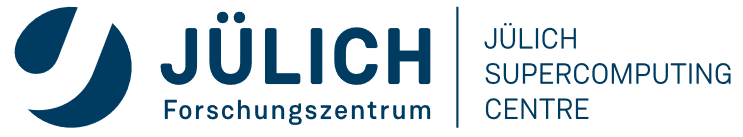

# Extending the default kernel

There are many cases where one needs modules from JupyterLab for a project. But building your own kernel is often a detour from the original idea or is annoying when publishing your project. By adding these 4 cells to the top of your project you can load modules for the project "on the fly".

Besides that this also adds a ways of installing python packages via pip without disrupting the uses packages or access to the system site-packages

-------

- First we create to temp-folders in the */tmp* directory, who will contain the venv where we install the required packages and a folder that stores the PYTHONPATH and LD_LIBRARY_PATH environment variable. This is necessary because loading modules manipulates these variables but we can't access the changes from within python, so we store the changed variables in a folder.
- Then we use a bash-shell to:
  - Load the Modules
  - Create a venv and installing ipykernel in there
  - Write PYTHONPATH and LD_LIBRARY_PATH to the tempdir
- Beacause the Dynamic Linker of Python doesn't detect changes in LD_LIBRARY_PATH we need to reboot the Interpreter afterwards to carry these changes over. To gain access to the venv we will start Python from there.
- After that we install the required modules.

**Note**: The third cell **won't** show that it's completed and the Notebook will show `Python 3 | Starting` at the bottom, although the interpreter already reloaded compeltely. You can savely ignore this and continue with the third shell. As soon as this has finished the Notebook will show `Python3 | Idle` again.

In [ ]:
import os, sys, tempfile

tempdir = tempfile.mkdtemp()
venv_folder = tempfile.mkdtemp()
print(tempdir, venv_folder)

In [ ]:
%%bash -s "$tempdir" "$venv_folder"  # Pass the paths to the bash-subshell

######################################################################
##                     The modules go here                          ##
##     We will use Stage/Devel-2020 with Python 3.8 as a example    ##
######################################################################

# Update to Stage Devel-2020
module --force purge
module use $OTHERSTAGES        
module load Stages/Devel-2020

module load GCC/9.3.0
module load Python/3.8.5

# Create a venv with the python from Devel-2020 and install ipykernel there (needed for communicating with Jupyter)
# If you don't change Python above this should be a normal Python 3.6 venv
python -m venv --system-site-packages $2
source $2/bin/activate
pip install --quiet ipykernel

# Store the new variables to the temp-folder
echo $PYTHONPATH > $1/pythonpath
echo $LD_LIBRARY_PATH > $1/librarypath

In [ ]:
# The arguments for the new python interpreter. We need to initialize ipykernel or JupyterLab will fail to integrate the new process
args = [f"{venv_folder}/bin/python", "-m", "ipykernel"]
args.extend(sys.argv)

# Because we call "execve" instead of "execv" we get the option to set the environment variables in the process. We use this to smuggle in the changed LD_LIBRARY_PATH and PYTHONPATH.
# You also can pass the location of the 2 temp-folders as new environment variables if you want to delete them later for cleanup.
env = {"PYTHONPATH": open(f"{tempdir}/pythonpath").read(),
       "LD_LIBRARY_PATH": open(f"{tempdir}/librarypath").read(),
       "tempdir": tempdir,
       "venv_folder": venv_folder}
 
!echo Restarting Interpreter from $venv_folder/bin/python. Please execute the next cell
os.execve(f"{venv_folder}/bin/python", args, env)

In [ ]:
# Because we are in the venv now, we can safely install all packages that we need and don't come with the Python3-Kernel. No need to add --user
%pip install --quiet ...

-----

After that you can import all you libraries (remember that the Interpreter restarted and you need to reimport os/sys/tempfile if you need them) and start with the notebook